In [21]:
import sys
print(sys.executable)

C:\Users\eliza\anaconda3\python.exe


In [22]:
# Import the necessary modules
import tensorflow as tf
import keras
from keras import datasets
from keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.regularizers import l2
from collections import Counter
from tensorflow.keras import losses


from keras import layers
from keras import regularizers

from keras.models import model_from_json

from IPython.display import clear_output

from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
import PIL.Image
import matplotlib.image as mpimg
import glob
from os import listdir
from os.path import isfile, join
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from itertools import cycle
import seaborn as sns
import datetime
import statistics as st
import plotly.express as px

from matplotlib.ticker import MaxNLocator

import pickle
import sklearn as skl

from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score

In [23]:
# Define some useful functions
class PlotLossAccuracy(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.acc = []
        self.losses = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(int(self.i))
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))
        # print(self.acc)
        # print(self.val_acc)
        # print(logs)
        
        self.i += 1
        
        clear_output(wait=True)
        plt.figure(figsize=(16, 6))
        plt.plot([1, 2])
        plt.subplot(121) 
        plt.plot(self.x, self.losses, label="train loss")
        plt.plot(self.x, self.val_losses, label="validation loss")
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.title('Model Loss')
        plt.legend()
        plt.subplot(122)         
        plt.plot(self.x, self.acc, label="training accuracy")
        plt.plot(self.x, self.val_acc, label="validation accuracy")
        plt.legend()
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.title('Model Accuracy')
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.show();
class PlotLoss(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        
        self.losses = []
        self.val_losses = []
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(int(self.i))
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        # print(self.acc)
        # print(self.val_acc)
        # print(logs)
        
        self.i += 1
        
        clear_output(wait=True)
        plt.figure(figsize=(16, 6))
        plt.plot([1, 2])
        plt.subplot(121) 
        plt.plot(self.x, self.losses, label="train loss")
        plt.plot(self.x, self.val_losses, label="validation loss")
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.title('Model Loss')
        plt.legend()
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.show();        
def save_model_to_disk(model_):    
    # save model and weights (don't change the filenames)
    model_json = model_.to_json()
    with open("python_model.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model_.save_weights("python_model.h5")
    print("Saved model to python_model.json and weights to python_model.h5")
    
def save_traintest_data(path, data, label):
    for i in range(len(data)):
        arr_label=str(label)+'/'+str(label)+'_arr'+str(i)+'.npy'
        np.save(path+arr_label, data[i], allow_pickle=True)
    return None 


### Load Data.

In [24]:
#Read in directories for each Flux/Polarization Spectrogram showing an LFE image.
mypath='C:/Users/eliza/Desktop/git_folder/ML_For_SKR_Code/ML_Dataset/LFE_Images_for_ML'
lfe_image_labels=[f for f in listdir(mypath) if isfile(join(mypath, f))]
lfe_files = ['C:/Users/eliza/Desktop/git_folder/ML_For_SKR_Code/ML_Dataset/LFE_Images_for_ML/'+f for f in lfe_image_labels]
count=int(len(lfe_files)/2)
flux_lfe_files = ['C:/Users/eliza/Desktop/git_folder/ML_For_SKR_Code/ML_Dataset/LFE_Images_for_ML/01_flux_img'+str(i)+'.png' for i in range(count)]
flux_lfe_files = [i for i in flux_lfe_files if i in lfe_files]
pol_lfe_files=['C:/Users/eliza/Desktop/git_folder/ML_For_SKR_Code/ML_Dataset/LFE_Images_for_ML/01_pol_img'+str(i)+'.png' for i in range(count)]
pol_lfe_files=[i for i in pol_lfe_files if i in lfe_files]


#Read in directories for each Flux/Polarization Spectrogram showing an non-LFE image.
mypath='C:/Users/eliza/Desktop/git_folder/ML_For_SKR_Code/ML_Dataset/NOLFE_Images_for_ML'
nolfe_image_labels=[f for f in listdir(mypath) if isfile(join(mypath, f))]
nolfe_files = ['C:/Users/eliza/Desktop/git_folder/ML_For_SKR_Code/ML_Dataset/NOLFE_Images_for_ML/'+f for f in nolfe_image_labels]
count=int(len(nolfe_files))
flux_nolfe_files = ['C:/Users/eliza/Desktop/git_folder/ML_For_SKR_Code/ML_Dataset/NOLFE_Images_for_ML/10_flux_img'+str(i)+'.png' for i in range(count)]
def get_index(label):
    if len(label) ==97:
        index = label[92]
    elif len(label) ==98:
        index=label[92:94]
    elif len(label) == 99:
        index = label[92:95]
    return index
flux_nolfe_files = [i for i in flux_nolfe_files if i in nolfe_files]
nolfe_image_indices = np.sort([int(get_index(i)) for i in flux_nolfe_files])
pol_nolfe_files=['C:/Users/eliza/Desktop/git_folder/ML_For_SKR_Code/ML_Dataset/NOLFE_Images_for_ML/10_pol_img'+str(i)+'.png' for i in nolfe_image_indices]



#Combine file strings 
flux_data_paths=flux_lfe_files+flux_nolfe_files
print(len(flux_lfe_files), len(flux_nolfe_files))
print(len(pol_lfe_files), len(pol_nolfe_files))

#### Here we load in data as images and convert to tensor flow array, and then combine flux and polarization data into one array for each image. The result will be a (48, 1240, 8) tensor for each instance.

#Function to read image and convert to numpy array.
def img_to_arr(infilename) :
    img = PIL.Image.open(infilename)
    img=tf.keras.utils.img_to_array(img, data_format=None, dtype=None)
    resize = tf.keras.Sequential([layers.Resizing(48, 1240),layers.Rescaling(1./255)])
    img = resize(img)
    
    return img

#Function to combine flux and polarization data.
def combine_channels(flux_file, pol_file):
    flux_arr = np.array(list(map(img_to_arr, flux_file)))
    pol_arr = np.array(list(map(img_to_arr, pol_file)))
    combnd_image_arrays=tf.concat([flux_arr,pol_arr], axis=3)
    #print(combnd_image_arrays.shape)
    return combnd_image_arrays  

#Function to extract label from image path.
def make_labels(img_string):
    #LFE =0 NOLFE=1
    char = img_string.split('/')[-1][0]
    #print(char)
    return char

pol_data_paths = pol_lfe_files + pol_nolfe_files
flux_data_paths=flux_lfe_files+flux_nolfe_files
print('There are ' + str(len(pol_lfe_files)) + ' images of LFEs')
print('There are ' + str(len(pol_nolfe_files)) + ' images without an LFE')
print('There are ' +str(len(pol_data_paths)) +' images in total')
total_data_arrays=combine_channels(flux_data_paths, pol_data_paths)
print('Total size of dataset:', total_data_arrays.shape)



556 463
556 463
There are 556 images of LFEs
There are 463 images without an LFE
There are 1019 images in total
Total size of dataset: (1019, 48, 1240, 8)


In [25]:
#### Make the Image Labels. LFE = 0, LFE_ext = 1, NOLFE = 2.

#Read in labels for LFE images.
ttl_labels =list(pd.read_excel('C:/Users/eliza/Desktop/git_folder/ML_For_SKR_Code/ML_Dataset/ML_LFE_Info.xlsx')['Note'])

#Remove LFE_dg label  if needs be.
ttl_labels=['LFE' if x == 'LFE_m' else x for x in ttl_labels]
ttl_labels=['LFE_sp' if x == 'LFE_ext' else x for x in ttl_labels]
#ttl_labels=['LFE' if x == 'LFE_sp' else x for x in ttl_labels]
ttl_labels=['LFE' if x == 'LFE_dg' else x for x in ttl_labels]
ttl_labels=['LFE' if x == 'LFE_sm' else x for x in ttl_labels]
ttl_labels=['NOLFE' if x == 'NoLFE' else x for x in ttl_labels]
print(np.unique(ttl_labels))
total_data_labels=list(pd.Categorical(pd.factorize(ttl_labels)[0]))
print(np.unique(total_data_labels))

['LFE' 'LFE_sp' 'NOLFE']
[0 1 2]


#### For this exercise, we will separate the polarization and flux data, and use black and white images (so one color channel).

(616, 1240, 4)


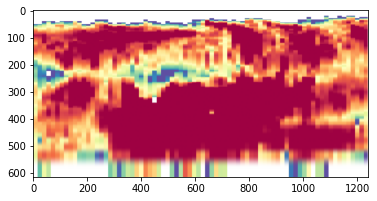

In [26]:
img=PIL.Image.open("C:/Users/eliza/Desktop/git_folder/ML_For_SKR_Code/ML_Dataset/LFE_Images_for_ML/01_flux_img0.png")
img_arr=tf.keras.utils.img_to_array(img, data_format=None, dtype=None)

print(img_arr.shape)
plt.imshow(img)
plt.show()

In [27]:
### Load Trajectory Data.

#### Latitude Arrays.

lfe_start = np.load('C:/Users/eliza/Desktop/git_folder/ML_For_SKR_Code/ML_Dataset/Temporary/lfe_start.npy',allow_pickle=True)
nolfe_start = np.load('C:/Users/eliza/Desktop/git_folder/ML_For_SKR_Code/ML_Dataset/Temporary/nolfe_start.npy',allow_pickle=True)
ttl_start = np.concatenate([lfe_start, nolfe_start])
ttl_years = [datetime.datetime.strftime(i, '%Y') for i in ttl_start]


mypath='C:/Users/eliza/Desktop/git_folder/ML_For_SKR_Code/ML_Dataset/Latitude_Arrays'
latitude_labels=[f for f in listdir(mypath) if isfile(join(mypath, f))]
latitude_files = ['C:/Users/eliza/Desktop/git_folder/ML_For_SKR_Code/ML_Dataset/Latitude_Arrays/'+f for f in latitude_labels]
latitude_arrays = np.array([np.load(i, allow_pickle=True) for i in latitude_files])
latitude_medians = np.array([st.median(i) for i in latitude_arrays])
latitude_std = np.array([np.std(i) for i in latitude_arrays])

#### Local Time Arrays.

mypath='C:/Users/eliza/Desktop/git_folder/ML_For_SKR_Code/ML_Dataset/LocalTime_Arrays'
lt_labels=[f for f in listdir(mypath) if isfile(join(mypath, f))]
lt_files = ['C:/Users/eliza/Desktop/git_folder/ML_For_SKR_Code/ML_Dataset/LocalTime_Arrays/'+f for f in lt_labels]
lt_arrays = np.array([np.load(i, allow_pickle=True) for i in lt_files])
lt_medians = np.array([st.median(i) for i in latitude_arrays])
lt_std = np.array([np.std(i) for i in latitude_arrays])

#### Divide Data into Training and Testing.

In [28]:
indices = np.arange(0, len(total_data_labels))
X_train, X_test, lat_medians_train, lat_medians_test,lat_stds_train, lat_stds_test,lt_medians_train, lt_medians_test,lt_stds_train, lt_stds_test,years_train, years_test, indices_train, indices_test, Y_train, Y_test = skl.model_selection.train_test_split(total_data_arrays.numpy(),latitude_medians, latitude_std, lt_medians, lt_std,ttl_years, indices,total_data_labels,test_size=0.2, random_state=42)
lt_medians_train = np.array(lt_medians_train)
Y_train = tf.keras.utils.to_categorical(Y_train)
Y_test = tf.keras.utils.to_categorical(Y_test)

#### Flattening

In [29]:
H =48
W=1240
C=8
flat_train = np.reshape(X_train,(-1, H * W * C))
flat_test = np.reshape(X_test,(-1, H * W * C))
print(X_train.shape, X_test.shape)

(815, 48, 1240, 8) (204, 48, 1240, 8)


### Model

#### Autoencoder
Autoencoders can be used to reduce the dimensions of the input image by using dense layers. The autoencoder can select the important features of the image by doing this. 

The autoencoder consists of encoder, code and decoder. The encoder compresses the image up until a maximum value, which is the code. The decoder reconstructs the image to its original shape. Resulting in a less detailed picture, but hopefully preserving the important features.

Dense layers are used because the number of nodes defines the output dimensions of the layer. For example for a Dense layer of 10 modes, no matter the input layer, there will be an output of size 10. Stacking dense layers is a simple way of building an autoencoder.

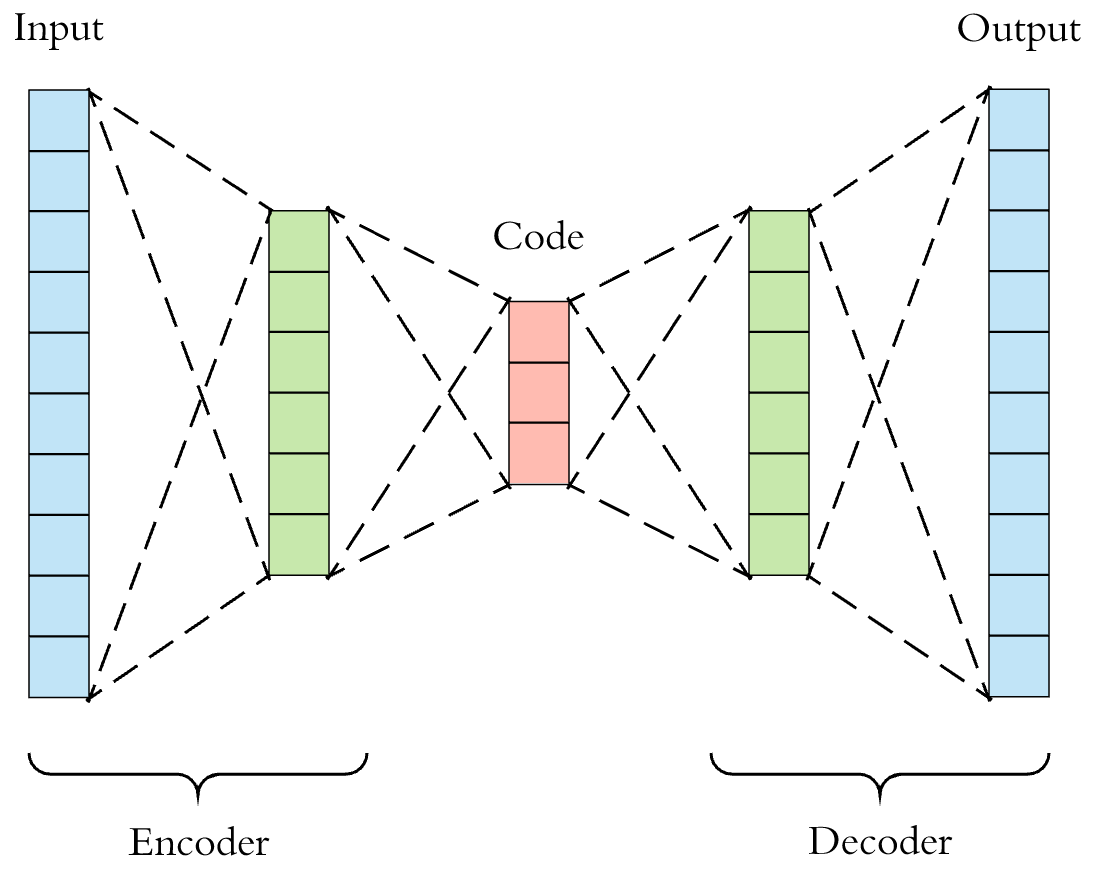

In [30]:
from IPython.display import Image
Image("C:/Users/eliza/Desktop/git_folder/ML_Exercises/Figures/1_ZEvDcg1LP7xvrTSHt0B5-Q@2x.png",width=400, height=400)

In [31]:
inputs = tf.keras.layers.Input(shape=(H*W*C))
dim0 = 72
dim1 = 12
dim2 = 2

#x = Flatten()(inputs)

encoder1 = Dense(dim0, activation='relu')(inputs)

encoder2 = Dense(dim1, activation='relu')(encoder1)

code = Dense(dim2, activation='relu',kernel_regularizer='l1')(encoder2)


decoder1 = Dense(dim1, activation='relu')(code)
decoder2 = Dense(dim0, activation='relu')(decoder1)
decoder3 = Dense(H * W * C, activation='sigmoid')(decoder2)



autoencoder=Model(inputs=inputs,outputs=decoder3)
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 476160)]          0         
                                                                 
 dense_8 (Dense)             (None, 72)                34283592  
                                                                 
 dense_9 (Dense)             (None, 12)                876       
                                                                 
 dense_10 (Dense)            (None, 2)                 26        
                                                                 
 dense_11 (Dense)            (None, 12)                36        
                                                                 
 dense_12 (Dense)            (None, 72)                936       
                                                                 
 dense_13 (Dense)            (None, 476160)            3475

#### Train Model

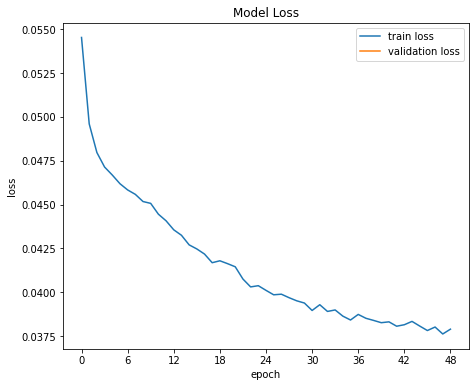

26/26 [==============================] - 7s 263ms/step - loss: 0.0379
Epoch 50/50
 9/26 [=========>....................] - ETA: 4s - loss: 0.0365

KeyboardInterrupt: 

In [40]:
pltCallBack = PlotLoss()

#opt = tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
autoencoder.fit(flat_train, flat_train, epochs=50, batch_size=32, verbose=1,callbacks=[pltCallBack])

In [41]:
train_pred = autoencoder.predict(flat_train)

print(np.reshape(train_pred[0], (H, W,C)).shape)

(48, 1240, 8)


#### Visualise Results of Autoencoder

(10, 2)


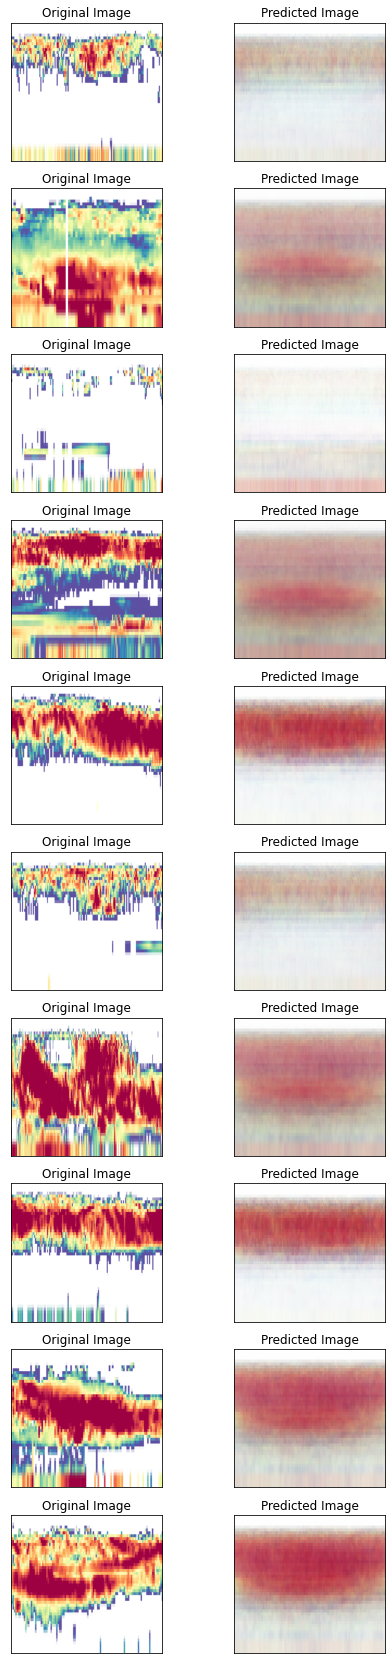

In [42]:
n=10
fig, axes=plt.subplots(n, 2,figsize=(8,30))
plt.subplots_adjust(wspace=0)
print(axes.shape)

for i in range(n):
    ax=axes[i, 0]
    #Display Original 
    ax.set_title('Original Image')
    img = np.reshape(flat_train[i],(H, W,C))
    img = img[:,:,0:4]
    img=tf.image.resize(img, [1500, 1640], method='nearest')
    ax.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    
    #Display Predicted
    ax=axes[i, 1]
    ax.set_title('Predicted Image')
    img = np.reshape(train_pred[i],(H, W,C))
    img = img[:,:,0:4]
    img=tf.image.resize(img, [1500, 1640], method='nearest')
    ax.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    

(10, 2)


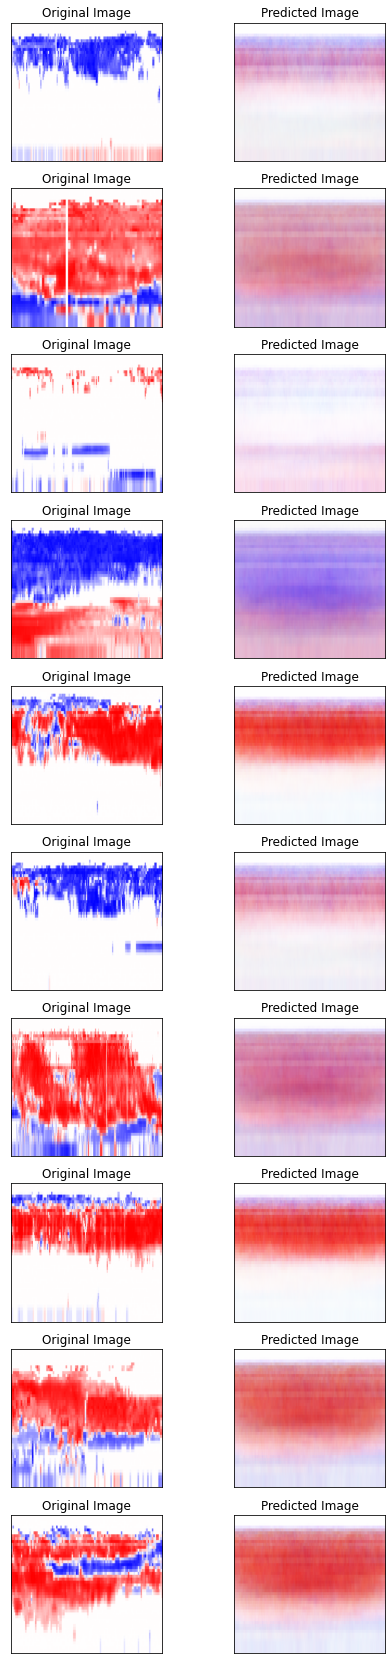

In [43]:
n=10
fig, axes=plt.subplots(n, 2,figsize=(8,30))
plt.subplots_adjust(wspace=0)
print(axes.shape)

for i in range(n):
    ax=axes[i, 0]
    #Display Original 
    ax.set_title('Original Image')
    img = np.reshape(flat_train[i],(H, W,C))
    img = img[:,:,4:]
    img=tf.image.resize(img, [1500, 1640], method='nearest')
    ax.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    
    #Display Predicted
    ax=axes[i, 1]
    ax.set_title('Predicted Image')
    img = np.reshape(train_pred[i],(H, W,C))
    img = img[:,:,4:]
    img=tf.image.resize(img, [1500, 1640], method='nearest')
    ax.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    

#### Classification

In [36]:
#save_model_to_disk(autoencoder)

[Text(0, 0.5, 'LFE'), Text(0, 1.5, 'LFE_ext'), Text(0, 2.5, 'No LFE')]

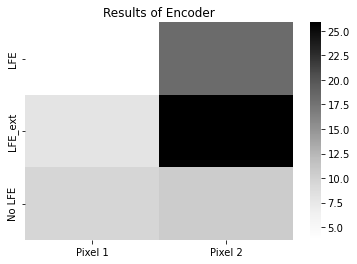

In [44]:
layer_name = [layer.name for layer in autoencoder.layers]


code_layer=layer_name[3]

successive_outputs = autoencoder.get_layer(code_layer).output


visualization_model = tf.keras.models.Model(inputs = autoencoder.input, outputs = successive_outputs)
successive_feature_maps = visualization_model.predict(flat_train)



integer_labels=[np.argmax(y, axis=None, out=None) for y in Y_train]
indices_LFE = [i for i,j in enumerate(integer_labels) if j ==0]
indices_LFEext = [i for i,j in enumerate(integer_labels) if j ==1]
indices_noLFE = [i for i,j in enumerate(integer_labels) if j ==2]

fm_LFE = successive_feature_maps[indices_LFE,:]
fm_LFEext = successive_feature_maps[indices_LFEext,:]
fm_noLFE = successive_feature_maps[indices_noLFE,:]



av_fm_LFE = st.mean(fm_LFE[:,0]),st.mean(fm_LFE[:,1])
av_fm_LFEext = st.mean(fm_LFEext[:,0]),st.mean(fm_LFEext[:,1])
av_fm_noLFE = st.mean(fm_noLFE[:,0]),st.mean(fm_noLFE[:,1])

av_fms = np.array([av_fm_LFE, av_fm_LFEext,av_fm_noLFE])

ax=sns.heatmap(av_fms,cmap='Greys')
ax.set_title('Results of Encoder')
ax.set_xticklabels(['Pixel 1', 'Pixel 2'])
ax.set_yticklabels(['LFE', 'LFE_ext', 'No LFE'])

In [55]:
code_df = pd.DataFrame(successive_feature_maps)
code_df['label']=integer_labels




fig = px.scatter(code_df, x=1, y=0, color="label",
          labels={"label"})
fig.update_layout(showlegend=True)
fig.update_coloraxes(showscale=True)
fig.update_traces(marker={'size': 5})
fig.update_xaxes(title='Pixel 2')
fig.update_yaxes(title='Pixel 1')
#fig.update_yaxes(type='log')
fig.show()


In [39]:
main_input = tf.keras.layers.Input(shape=(dim2))
#Latitude Input
latitude_input_1= tf.keras.layers.Input(shape=(1))
latitude_input_2= tf.keras.layers.Input(shape=(1))
#Local Time Input
lt_input_1= tf.keras.layers.Input(shape=(1))
lt_input_2= tf.keras.layers.Input(shape=(1))



#x = Flatten()(main_input)
x = tf.concat([main_input, latitude_input_1, latitude_input_2, lt_input_1, lt_input_2], axis=1)
x = Dense(50, activation='relu')(x)
#x=Dropout(0.2)(x)
#x = Dense(5, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

classifier=Model(inputs=[main_input,latitude_input_1, latitude_input_2, lt_input_1, lt_input_2 ],outputs=predictions)
opt = tf.keras.optimizers.SGD(learning_rate=0.000001, decay=1e-6, momentum=0.9, nesterov=True)
#opt = tf.keras.optimizers.RMSprop(learning_rate=0.001, decay=1e-6, momentum=0.9)
#opt='Adam'

# compile
classifier.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# we create a callback function to plot our loss function and accuracy
pltCallBack = PlotLossAccuracy()
classifier.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, 1)]          0           []                               
                                                                                            

Make sure that the encoder layer does not continue to be trained.

In [39]:
#classifier.get_layer("dense_57").trainable = False
#classifier.get_layer("dense_58").trainable = False

Train the model.

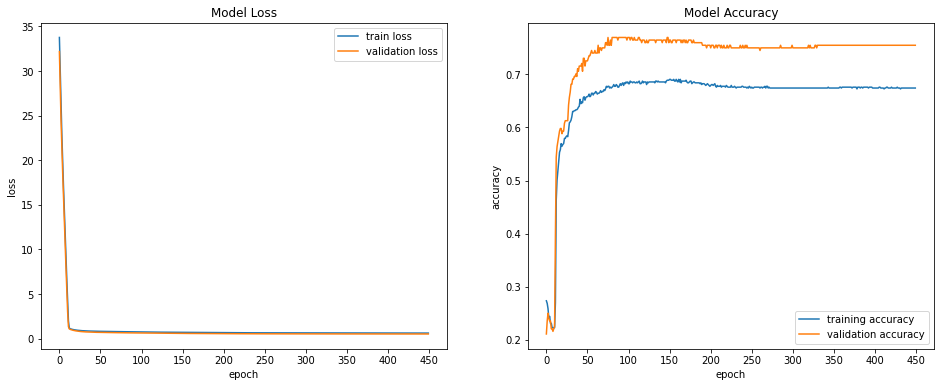

25/25 [==============================] - 0s 8ms/step - loss: 0.6290 - accuracy: 0.6743 - val_loss: 0.5297 - val_accuracy: 0.7549


In [20]:
ttl_train = [X_train, lat_medians_train, lat_stds_train, lt_medians_train, lt_stds_train]
ttl_test=[X_test, lat_medians_test, lat_stds_test, lt_medians_test, lt_stds_test]
encoded_train = [successive_feature_maps, lat_medians_train, lat_stds_train, lt_medians_train, lt_stds_train]
classifier.fit(encoded_train, Y_train,
          batch_size=25,validation_split=0.25, epochs=450,shuffle=True,   
         callbacks=[pltCallBack])

In [ ]:
test = classifier.predict(ttl_test, Y_test)